# Natural Computing - Project
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

The code below uses the DEAP framework (https://github.com/deap/deap), which is a very intuitive framework for evolutionary algorithms and genetic programming.

### Installing the DEAP framework

In [1]:
!pip install deap

### Imports

In [2]:
from deap import gp, base, tools, creator, algorithms
import numpy as np
import matplotlib.pyplot as plt
import operator
import pandas as pd
import math

%matplotlib inline

### Define fitness function

In [22]:
mnist_df = pd.read_csv("mnist.csv")

In [23]:
zeros_ones_df = mnist_df[mnist_df.label <= 1]

In [25]:
zeros_ones_labels = zeros_ones_df['label'].to_numpy()
zeros_ones_data = zeros_ones_df.drop('label', axis=1).to_numpy()

In [ ]:
def fitness(individual, points):
    # Transform tree expression into callable function
    func = toolbox.compile(expr=individual)
    # Compute sum of absolute errors
    error = 0
    for x, y in points.items():
        error += abs(func(x) - y)
    return -error

### Defining the set of operators and terminals

In [3]:
# Create set of functions and terminals, with one terminal: x
pset = gp.PrimitiveSet("main", 1)
pset.renameArguments(ARG0="x")

In [4]:
# Define additional operators

### Basic mathematical functions with caveats ###

def div(a,b):
    # Ensure no division by 0 takes place
    return a/b if b else 0

def log(a):
    # Ensure no logarithm is taken of a non-positive value
    return math.log(a) if (a > 0) else 0

def exp(a):
    # Ensure no exponential is too big
    return math.exp(min(a,100))


### Activation functions ###

def relu(a):
    return a if a > 0.0 else 0.0

def sigmoid(a):
    return 1.0/(1.0 + math.exp(-a))

def tanh(a):
    return math.tanh(a)

In [5]:
# Add standard math operators to the set
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.cos, 1)

# Add math operators with caveats to the set
pset.addPrimitive(div, 2)
pset.addPrimitive(log, 1)
pset.addPrimitive(exp, 1)

# Add activation functions to the set
pset.addPrimitive(relu, 1)
pset.addPrimitive(sigmoid, 1)
pset.addPrimitive(tanh, 1)

### Define the creator that creates individuals (i.e. trees)

In [6]:
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

### Define the toolbox 
<b>(describes how to form a population, compile an expression as a function, evaluate fitness, select parents, perform cross-over and mutation)</b>

In [12]:
toolbox = base.Toolbox()
# Initial generation is generated using ramped half-and-half initialization, with a tree size between 1 and 5
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
# Define how to generate a population of individuals
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Define how to compile a tree as a function that can be evaluated
toolbox.register("compile", gp.compile, pset=pset)
# Define how to determine the fitness of an individual (using the fitness function defined above)
toolbox.register("evaluate", fitness, points=solution_dict)

# Define how to select parents (tournament selection; either controlling for bloat or not controlling for it)
if CONTROL_BLOAT:
    toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=1.3, fitness_first=False)
else:
    toolbox.register("select", tools.selTournament, tournsize=3) # Do not control
# Define how to perform cross-over (pick one node of both parents & swap subtrees)
toolbox.register("mate", gp.cxOnePoint)
# Define how to perform mutation (not very important as mutation probability is set to 0)
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Define upper limits for height of trees
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))

NameError: name 'fitness' is not defined

### Define statistics that will be gathered

In [9]:
# Functions for determining average, min and max, which control for the possibility that the input might consist of tuples
def tuple_avg(a):
    if len(a[0]) == 2:
        return np.mean([x[0] for x in a])
    return np.mean(a)

def tuple_min(a):
    if len(a[0]) == 2:
        return np.min([x[0] for x in a])
    return np.min(a)

def tuple_max(a):
    if len(a[0]) == 2:
        return np.max([x[0] for x in a])
    return np.max(a)

# Function for determining the size of the agent with the best fitness
def tuple_best_size(a):
    if len(a[0]) == 2:
        return np.amax(a, 1)[0]
    return None

In [10]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(lambda ind: [len(ind), ind.fitness.values[0]])
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg",  tuple_avg)
mstats.register("min",  tuple_min)
mstats.register("max",  tuple_max)
mstats.register("best", tuple_best_size)

### Run the genetic programming algorithm using the definitions above

In [11]:
pop = toolbox.population(POP_SIZE)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(population=pop, 
                               toolbox=toolbox, 
                               cxpb=CROSSOVER_PROB, 
                               mutpb=MUTATION_PROB, 
                               ngen=N_GENERATIONS, 
                               stats=mstats, 
                               halloffame=hof, 
                               verbose=True)

   	      	                               fitness                                	                     size                     
   	      	----------------------------------------------------------------------	----------------------------------------------
gen	nevals	avg         	best	gen	max     	min         	nevals	avg  	best	gen	max	min	nevals
0  	1000  	-5.37623e+40	None	0  	-4.24698	-5.37623e+43	1000  	9.419	7   	0  	43 	2  	1000  
1  	704   	-19.0204    	None	1  	-4.24698	-322.72     	704   	7.978	3   	1  	44 	2  	704   
2  	682   	-2.68812e+40	None	2  	-3.91227	-2.68812e+43	682   	7.358	4   	2  	40 	2  	682   
3  	686   	-719668     	None	3  	-3.51482	-3.59822e+08	686   	7.201	3   	3  	40 	2  	686   
4  	662   	-17.2326    	None	4  	-1.81107	-2088.88    	662   	8.023	2   	4  	38 	2  	662   
5  	704   	-7.14408e+07	None	5  	-1.81107	-6.52066e+10	704   	9.266	4   	5  	42 	2  	704   
6  	716   	-4.2485e+06 	None	6  	-1.81107	-4.24849e+09	716   	10.494	6   	6  	39 	2  	716   
7  	7

### Inspect best solution found

In [12]:
print(str(hof[0]))

log(add(cos(mul(add(mul(sin(exp(mul(x, mul(exp(mul(x, mul(sin(exp(x)), mul(add(mul(exp(x), x), log(exp(exp(x)))), mul(add(x, x), x))))), add(mul(exp(mul(x, mul(add(x, mul(x, log(x))), x))), x), log(mul(x, x))))))), mul(exp(x), x)), log(exp(exp(x)))), x)), mul(add(mul(x, x), x), exp(add(mul(add(x, x), x), x)))))


### Plotting

In [13]:
# Extract fitness of best individual in each generation
max_fitness = log.chapters["fitness"].select("max")

# Extract average, minimum and maximum size in each generation, as well as size corresponding to agent with best fitness
avg_size = log.chapters["size"].select("avg")
min_size = log.chapters["size"].select("min")
max_size = log.chapters["size"].select("max")
best_size = log.chapters["size"].select("best")

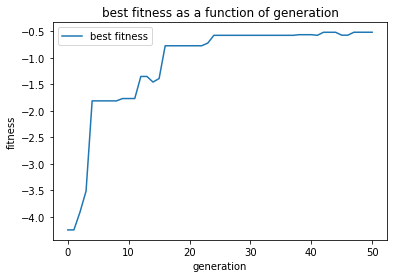

In [14]:
# Plot best fitness as a function of generation
plt.plot(max_fitness, label="best fitness")
plt.legend(loc="upper left")
plt.title("best fitness as a function of generation")
plt.xlabel("generation")
plt.ylabel("fitness")
plt.show()

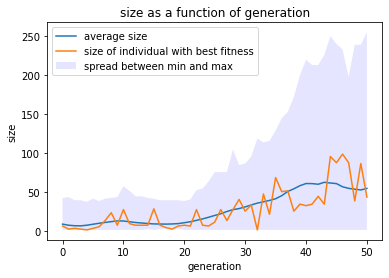

In [15]:
# Plot size as a function of generation
plt.plot(avg_size, label="average size")
plt.fill_between(np.arange(0,51,1), min_size, max_size, facecolor="blue", alpha=0.1, label="spread between min and max")
plt.plot(best_size, label="size of individual with best fitness")
plt.legend(loc="upper left")
plt.title("size as a function of generation")
plt.xlabel("generation")
plt.ylabel("size")
plt.show()